In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, lars_path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from collections import defaultdict

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read KS data collected in January
# ks_df = pd.read_csv('./kickstarter_data/01.csv', index_col=0)
# relevant_categories = ['design/product design', 'fashion/apparel', 'fashion/accessories', 'fashion', 'technology/gadgets', 'fashion/footwear', 'fashion/ready-to-wear', 'art/textiles', 'fashion/childrenswear', 'fashion/couture', 'technology/wearables']
# relevant_df = ks_df[ks_df.category.isin(relevant_categories)]

In [3]:
# Read Amzn Data
amz_df = pd.read_csv('./amazon_data/Duffel.csv')
amz_df_tt = pd.read_csv('./amazon_data/TravelTote.csv')
amz_df_luggage = pd.read_csv('./amazon_data/Luggage.csv')

In [4]:
new_df = pd.concat([amz_df, amz_df_tt, amz_df_luggage], ignore_index=True)

In [5]:
new_df.head()

,1 Stars,2 Stars,3 Stars,4 Stars,5 Stars,Brand,Name,Price,Product Details,Product Details Alt,Review Count,Star Rating,Styles,Url
0,1 star (10%),2 star (7%),3 star (9%),4 star (15%),5 star (59%),NaN,Herschel Supply Co. Novel Duffle Bag,65.00,NaN,Product Dimensions: 11 x 20.5 x 11.5 inches; ...,751 customer reviews,4.2 out of 5 stars,Black Grid; Black/Black; Black/Blueprint/White...,NaN
1,1 star (3%),2 star (3%),3 star (4%),4 star (18%),5 star (72%),Ledmark,Ledmark Heavyweight Cotton Canvas Outback Duff...,25.99 - 149.99,NaN,Shipping Information: View shipping rates and...,684 customer reviews,4.6 out of 5 stars,Green; Black,NaN
2,1 star (15%),2 star (7%),3 star (8%),4 star (16%),5 star (54%),NaN,Olympia USA 33 Inch 8 Pocket Rolling Duffel,42.99,NaN,Package Dimensions: 32 x 12 x 5 inches; Shipp...,1158 customer reviews,3.7 out of 5 stars,Black; Black w/ Beige - Exclusive Color; Charc...,NaN
3,1 star (6%),2 star (5%),3 star (8%),4 star (19%),5 star (62%),NaN,"Olympia Luggage 22"" 8 Pocket Rolling Duffel Bag",27.97,NaN,Product Dimensions: 12 x 12 x 22 inches; Ship...,1621 customer reviews,4.3 out of 5 stars,Black; Black / Gray; Black w/ Beige - Exclusiv...,NaN
4,1 star (5%),2 star (6%),3 star (6%),4 star (14%),5 star (69%),Plambag,Plambag Unisex's Canvas Duffel Bag Oversized T...,29.99,NaN,Shipping Weight: 3 pounds (View shipping rate...,739 customer reviews,4.3 out of 5 stars,Grey; Army Green; Coffee; Dark Grey,NaN


In [6]:
new_df.shape

(13038, 14)

In [7]:
def extract_rating(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        rating = float(input_string[0:3])
        return rating

In [8]:
new_df['Rating'] = new_df['Star Rating'].apply(extract_rating)

In [9]:
def extract_review_count(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        pattern = re.compile('(\d*)\s')
        review_count = int(re.search(pattern, input_string).group(1))
        return review_count

new_df['review_count'] = new_df['Review Count'].apply(extract_review_count)

In [10]:
def convert_stars(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        pattern = re.compile('(\d*)\%')
        percent_string = re.search(pattern, input_string).group(1)
        percent_decimal = int(percent_string)/100
        return percent_decimal
    
new_df['1Star'] = new_df['1 Stars'].apply(convert_stars)*new_df['review_count']
new_df['2Star'] = new_df['2 Stars'].apply(convert_stars)*new_df['review_count']
new_df['3Star'] = new_df['3 Stars'].apply(convert_stars)*new_df['review_count']
new_df['4Star'] = new_df['4 Stars'].apply(convert_stars)*new_df['review_count']
new_df['5Star'] = new_df['5 Stars'].apply(convert_stars)*new_df['review_count']

In [11]:
def count_styles(input_string):
    if pd.isnull(input_string):
        return 1
    else:
        style_count = len(input_string.split(';'))
        return style_count
        

In [12]:
new_df['style_count'] = new_df['Styles'].apply(count_styles)

In [13]:
def convert_to_dict(input_string):
    if pd.isnull(input_string):
        return np.nan
    else:
        details = {}
        list_details = [ l.split(':') for l in input_string.split(';')]
#         print(list_details)
        for detail_pair in list_details:
            if len(detail_pair) == 2:
                details[detail_pair[0].strip()] = detail_pair[1].strip()
        return details

In [14]:
# Combine the rows where value = NaN
new_df['prod_details'] = new_df[['Product Details', 'Product Details Alt']].applymap(lambda x: '' if pd.isnull(x) else x ).apply(lambda x: x[0] + x[1], axis=1)

In [15]:
new_df['prod_details'] = new_df['prod_details'].map(convert_to_dict)

In [16]:
# Create dictionary to track all product detail categories
d = defaultdict(int)

for detail_dict in new_df['prod_details']:
    if pd.isnull(detail_dict):
        next
    else:
        for ke in detail_dict:
            d[ke] += 1

In [17]:
sorted_keys = sorted(d, key=lambda x: d[x], reverse=True)
for k in sorted_keys[:15]:
    print (k, d[k])

ASIN 12987
Average Customer Review 12252
Amazon Best Sellers Rank 11916
Date first available at Amazon.com 11715
Shipping Weight 11481
Item model number 9643
Product Dimensions 8290
Package Dimensions 2197
Domestic Shipping 1595
International Shipping 1595
Shipping Information 1438
Customer Reviews 735
Best Sellers Rank 674
Item Weight 669
California residents 647
Manufacturer 347
Department 148
Date First Available 94
Shipping Advisory 64
Manufacturer recommended age 55
Color 49
Manufacturer Part Number 46
 45
UPC 40
Brand 34
Part Number 31
Size 31
Item Package Quantity 30
Batteries Required? 24
Discontinued by manufacturer 21
Batteries Included? 19
Brand Name 19
Model 17
Folding 15
Material 10
Batteries 9
Style 8
Warranty Description 7
Special Features 7
Item Dimensions L x W x H 7
Material Type 5
Number of Items 4
Vehicle Service Type 4
Number of Handles 3
Handle 2
Weight 2
OEM Part Number 2
Series 2
Shipping 2
Assembled Height 2


In [18]:
def get_asin(details_dict):
    if pd.isnull(details_dict):
        asin = np.nan
    else:
        try:
            asin = details_dict['ASIN']
        except:
            asin = np.nan
#     print(asin)
    return asin

In [19]:
new_df['asin'] = new_df['prod_details'].map(get_asin)

In [20]:
def get_rank(details_dict):
    if pd.isnull(details_dict):
        ranking = np.nan
    else:
        try:
            ranking = details_dict['Amazon Best Sellers Rank']
        except:
            try:
                ranking = details_dict['Best Sellers Rank']
            except:
                ranking = np.nan
#     print(ranking)
    return ranking

new_df['amazon_ranking'] = new_df['prod_details'].map(get_rank)

In [21]:
# get date launch
def get_date(details_dict):
    if pd.isnull(details_dict):
        date = np.nan
    else:
        try:
            date = details_dict['Date first available at Amazon.com']
            date = pd.to_datetime(date)
        except:
            date = np.nan
    return date

new_df['date_launch'] = new_df['prod_details'].map(get_date)
new_df['days_since_launch'] = (pd.to_datetime('today') - new_df['date_launch']).map(lambda x: x.days)

In [22]:
# Convert styles to list
new_df['styles'] = new_df['Styles'].str.split(';')

In [23]:
# Extract weight
def get_weight(details_dict):
    if pd.isnull(details_dict):
        weight = np.nan
    else:
        try:
            weight_string = details_dict['Shipping Weight'].strip()
            weight_list = weight_string.split('(')[0].split(' ')
            if weight_list[1] == 'pounds':
                weight = float(weight_list[0]) * 16
            elif weight_list[1] == 'ounces':
                weight = float(weight_list[0])
            else:
                weight = np.nan
                print(weight_list)
        except:
            weight = np.nan
#         print(weight)
    return weight



In [24]:
new_df['weight_ounces'] = new_df['prod_details'].map(get_weight)

In [25]:
def get_volume(details_dict):
    volume_unit = np.nan
    volume_string = np.nan
    if pd.isnull(details_dict):
        volume = np.nan
    else:
        try:
            if details_dict['Product Dimensions']:
                volume_string = details_dict['Product Dimensions']
#             elif details_dict['Package Dimensions']:
#                 volume_string = details_dict['Package Dimensions']
            volume_list = volume_string.split('x')
            last_unit = volume_list[-1]
            [volume_list[-1], volume_unit] = last_unit.strip().split(' ')
            volume_list = [float(num.strip()) for num in volume_list]
            volume = np.prod(volume_list)
        except:
            volume = np.nan
    return volume_string, volume, volume_unit, 

In [26]:
volume_results = pd.DataFrame(list(new_df['prod_details'].map(get_volume)))

In [27]:
new_df['volume_dimensions'], new_df['volume'], new_df['volume_unit']= volume_results[0], volume_results[1], volume_results[2]

In [28]:
# Verify that all volumes are in inches
new_df[(new_df['volume_unit'].notnull()) & (new_df['volume_unit'] != 'inches')].shape

(0, 32)

In [29]:
def get_min_max_price(input_str):
    if pd.isnull(input_str):
        min_price, max_price = np.nan, np.nan
    else:
        min_price, max_price = np.nan, np.nan
        prices = input_str.split('-')
        if len(prices) >= 1:
            min_price = float(prices[0])
        if len(prices) >= 2:
            max_price = float(prices[1])
#     if pd.isnull(min_price):
#         print(input_str)
    return min_price, max_price

In [30]:
price_results = pd.DataFrame(list(new_df['Price'].map(get_min_max_price)))

In [31]:
new_df['min_price'], new_df['max_price'] = price_results[0], price_results[1]

In [32]:
def get_first_ranking(string):
    if pd.isnull(string):
        rank = np.nan
        category = np.nan
    else:
        try:
            first_ranking = string.split('(')[0].split(' ')
            rank = int(first_ranking[0].replace('#', ''))
            category = (' ').join(first_ranking[2:]).strip()
#             print(rank, category)
        except:
            rank = np.nan
            category = np.nan
    return rank, category

In [33]:
rankings_results = pd.DataFrame(list(new_df['amazon_ranking'].map(get_first_ranking)))

In [34]:
new_df['amazon_rank'], new_df['rank_category'] = rankings_results[0], rankings_results[1]

In [35]:
new_df.drop(['Price', '1 Stars', '2 Stars', '3 Stars', '4 Stars', '5 Stars', 'Product Details', 'Product Details Alt', 'Star Rating', 'Review Count', 'amazon_ranking', 'Styles', 'date_launch', 'prod_details', ], axis=1, inplace=True)

In [36]:
df = new_df[new_df['rank_category'] == 'Clothing Shoes & Jewelry'].reset_index()

In [37]:
print('before dropping null targets', df.shape)
# Drop all rows where amazon_rank does not exist
df = df[pd.notnull(df['amazon_rank'])]
print('after dropping null targets', df.shape)

before dropping null targets (11029, 23)
after dropping null targets (11029, 23)


In [38]:
# Set inverse rank
# df['inverse_rank'] = 21112839 - df['amazon_rank']

In [41]:
df[df['review_count'] < 15].shape

(8827, 23)

In [42]:
# Log amazon rank to address skewness
df['log_rank'] = np.log(df['amazon_rank'])

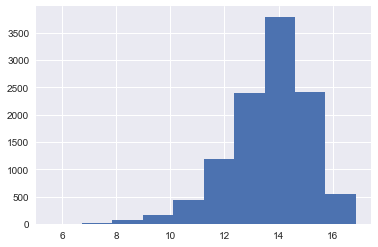

In [44]:
df['log_rank'].hist()

In [40]:
# Check how many NaN in each column
df.isnull().sum()

index                    0
Brand                 3743
Name                     1
Url                   3379
Rating                   0
review_count             0
1Star                    0
2Star                    0
3Star                    0
4Star                    0
5Star                    0
style_count              0
asin                     0
days_since_launch        2
styles                5330
weight_ounces         1331
volume_dimensions     3983
volume                3983
volume_unit           3983
min_price              570
max_price            10696
amazon_rank              0
rank_category            0
dtype: int64

In [65]:
# Create new df with no unnecessary columns; Volume units are all inches, so it doesn't matter
df_vol = df.drop(['index', 'Brand', 'Name', 'Url', 'styles', 'volume_dimensions', 'rank_category', 'asin', 'volume_unit', 'max_price'], axis=1).copy()

# Create alternate df with no volume because too many NaN in that column
df_novol = df_vol.drop(['volume'], axis=1).copy()

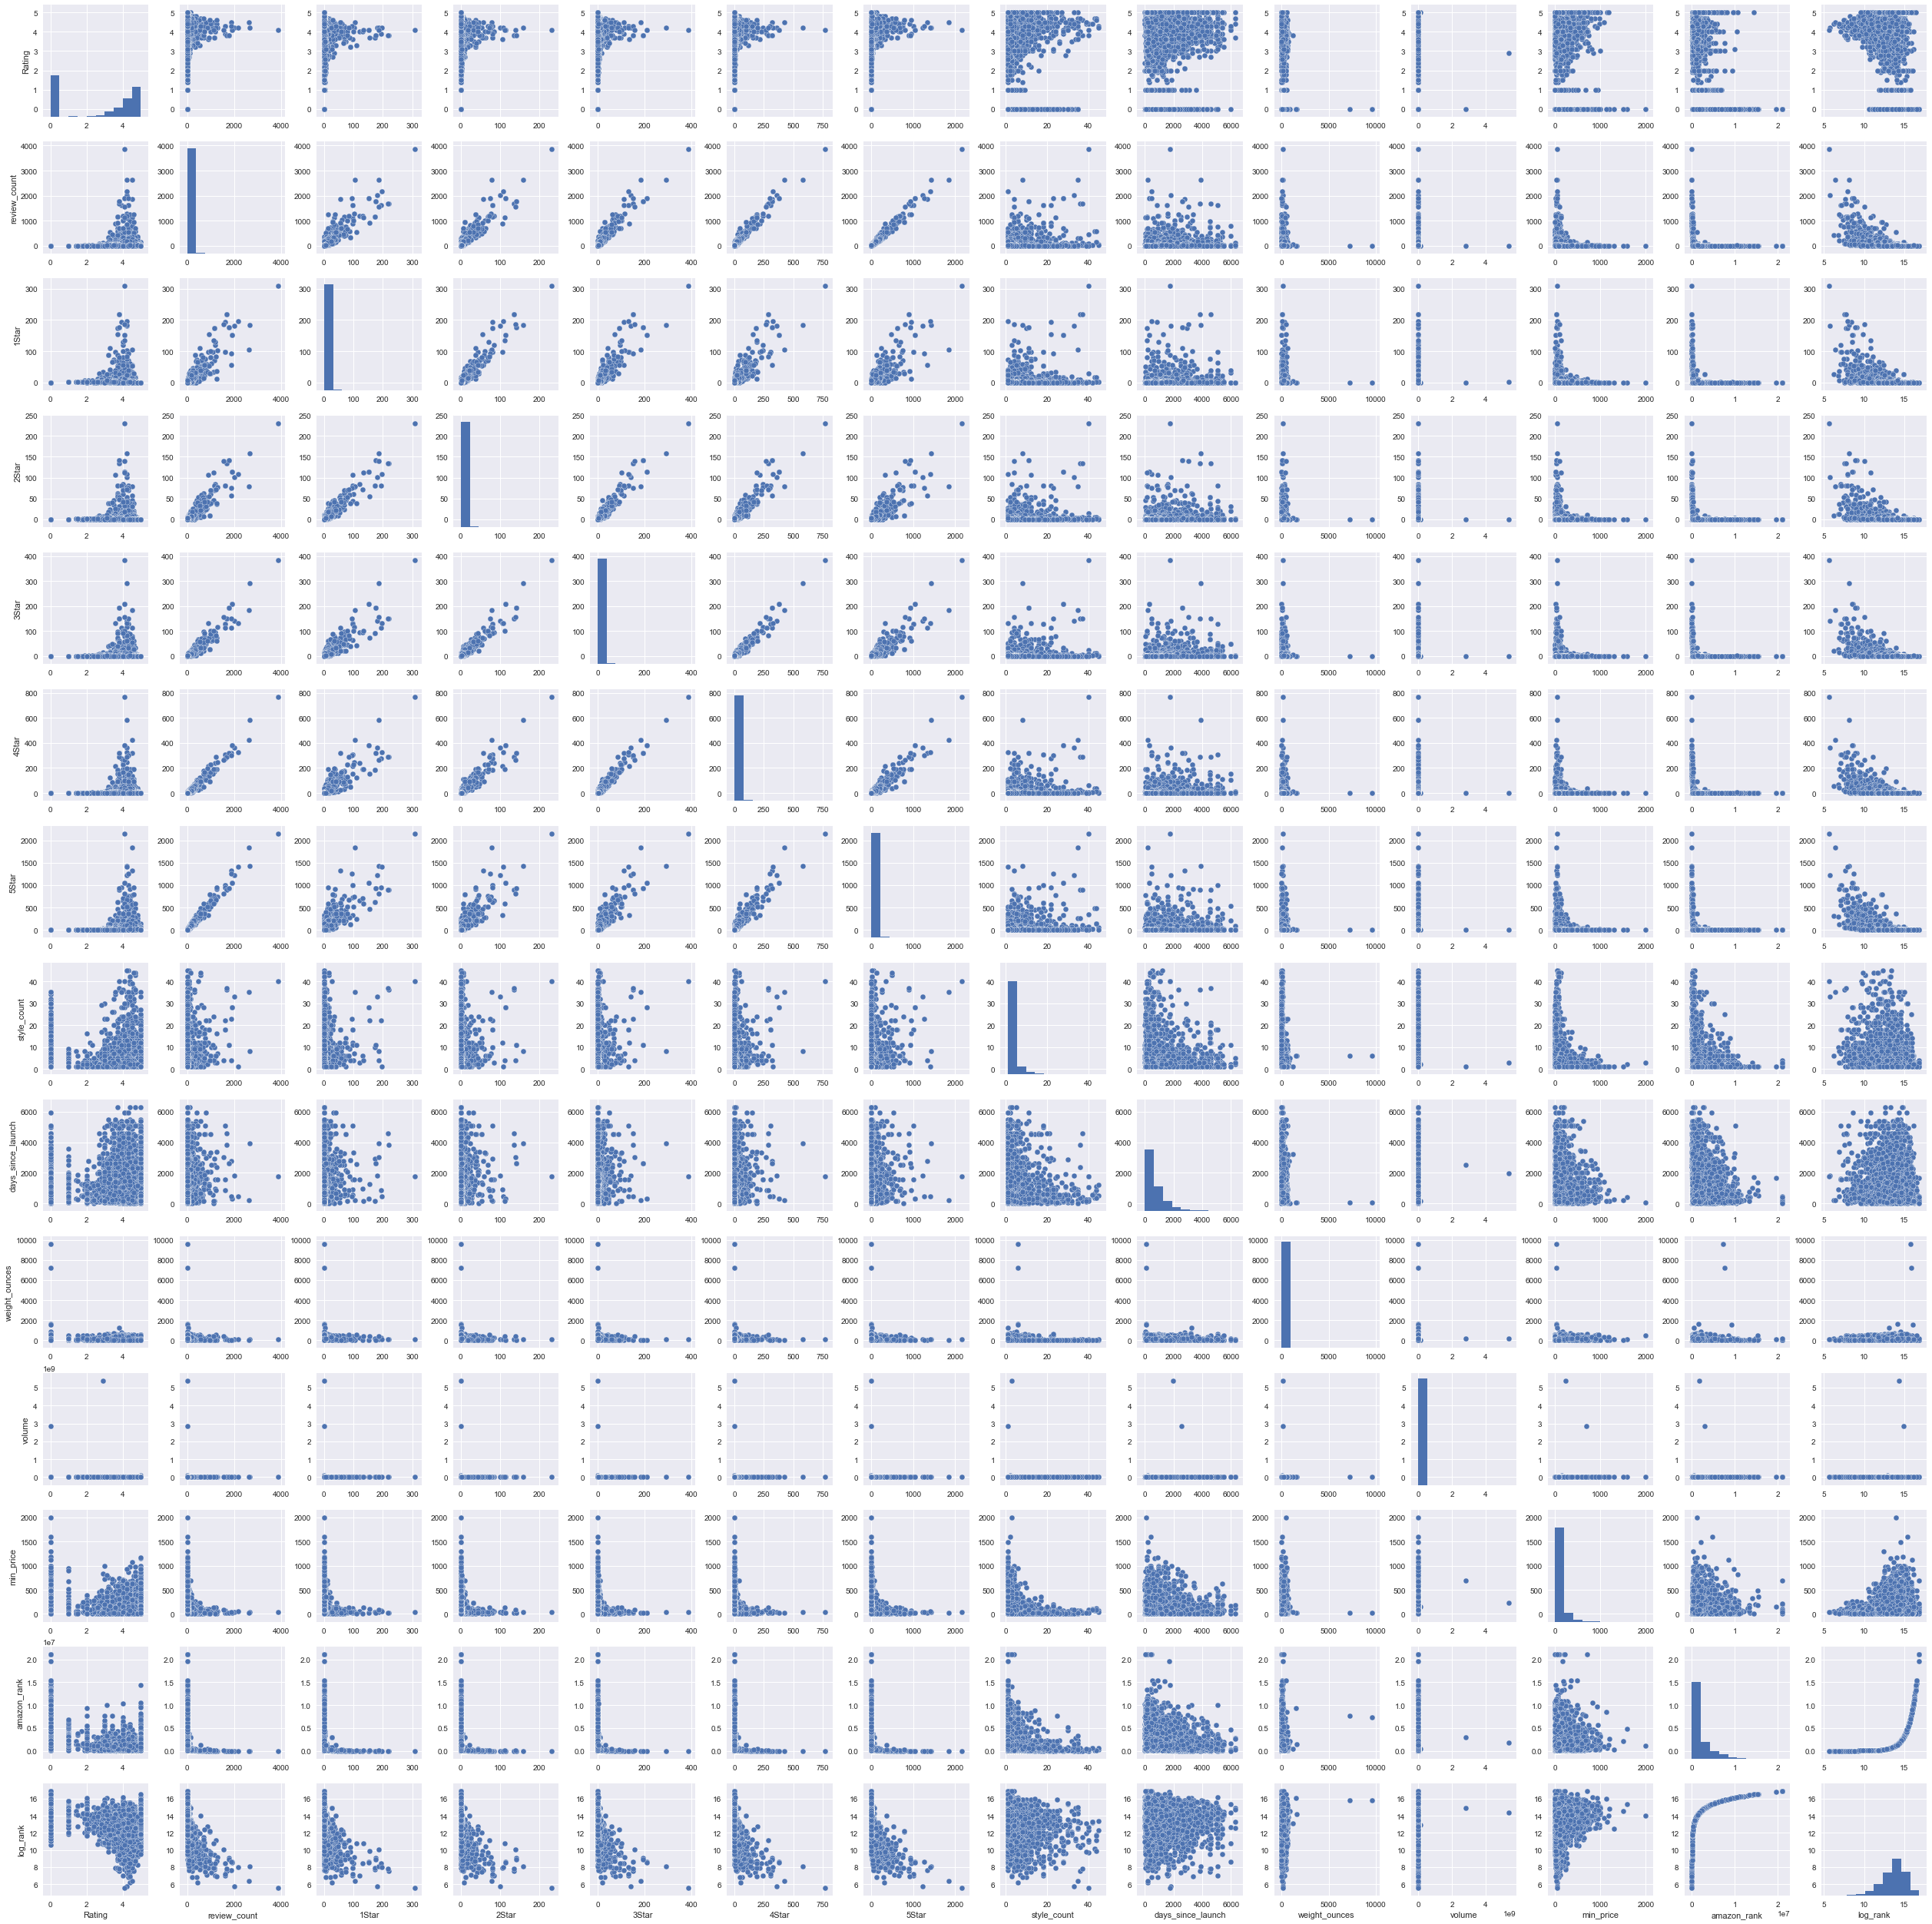

In [46]:
# Will not run with NaN values, so filling dummy with 0
sns.pairplot(df_vol.fillna(0))

In [66]:
# Drop all rows with NaN values
df_vol = df_vol.dropna()
df_novol = df_novol.dropna()

In [50]:
df_novol.shape

(9303, 13)

In [70]:
X=df_vol.loc[:,['Rating', 'review_count', '1Star', '2Star', '3Star', '4Star', '5Star',
       'style_count', 'days_since_launch', 'weight_ounces', 'volume',
       'min_price']]

y=df_vol['log_rank']


In [69]:
model = sm.OLS(y,sm.add_constant(X), missing="drop")
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rank   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     450.6
Date:                Sat, 03 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:35:56   Log-Likelihood:                -10245.
No. Observations:                6719   AIC:                         2.051e+04
Df Residuals:                    6707   BIC:                         2.060e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.3013      0.031    468.119      0.000      14.241      14.361
Rating               -0.2715      0.007    -38.599      0.000      -0.285      -0.258
review_count      -2.157e-05      0.001     -0.029      0.977      -0.002       0.001
1Star                -0.0041      0.005     -0.886      0.375      -0.013       0.005
2Star                -0.0236      0.009     -2.667      0.008      -0.041      -0.006
3Star                 0.0175      0.007      2.586      0.010       0.004       0.031
4Star                 0.0252      0.004      5.961      0.000       0.017       0.033
5Star                -0.0149      0.001    -14.790      0.000      -0.017      -0.013
style_count          -0.0332      0.004     -9.005      0.000      -0.040      -0.026
days_since_launch     0.0002   1.56e-05     15.484      0.000       0.000       0.000
weight_ounces        -0.0005   7.69e-05     -6.495      0.000      -0.001      -0.000
volume             5.917e-11   1.83e-10      0.323      0.747      -3e-10    4.18e-10
min_price             0.0003      0.000      2.816      0.005    9.29e-05       0.001
==============================================================================
Omnibus:                      293.536   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              634.460
Skew:                          -0.289   Prob(JB):                    1.69e-138
Kurtosis:                       4.390   Cond. No.                     3.18e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.66e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0,0.5,'Residual')

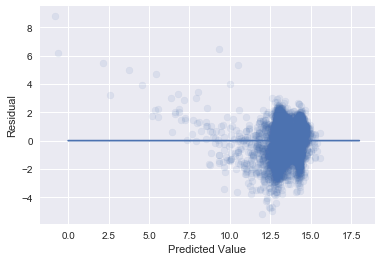

In [77]:
y_pred = results.predict(sm.add_constant(X))
plt.scatter(y_pred,y-y_pred,alpha=.1)
plt.plot(np.linspace(0,18,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [61]:
X=df_novol.loc[:,['Rating', 'review_count', '1Star', '2Star', '3Star', '4Star', '5Star',
       'style_count', 'days_since_launch', 'weight_ounces', 'min_price']]

# y=df_novol['amazon_rank']
y=df_novol['log_rank']

model = sm.OLS(y,sm.add_constant(X), missing="drop")
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rank   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     660.8
Date:                Sat, 03 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:34:00   Log-Likelihood:                -14267.
No. Observations:                9303   AIC:                         2.856e+04
Df Residuals:                    9292   BIC:                         2.864e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.4359      0.024    596.854      0.000      14.388      14.483
Rating               -0.2788      0.006    -48.169      0.000      -0.290      -0.267
review_count         -0.0021      0.001     -3.115      0.002      -0.003      -0.001
1Star                 0.0002      0.004      0.057      0.955      -0.008       0.009
2Star                -0.0332      0.008     -4.228      0.000      -0.049      -0.018
3Star                 0.0157      0.006      2.623      0.009       0.004       0.027
4Star                 0.0261      0.004      6.968      0.000       0.019       0.033
5Star                -0.0109      0.001    -12.551      0.000      -0.013      -0.009
style_count          -0.0360      0.003    -12.241      0.000      -0.042      -0.030
days_since_launch     0.0002   1.37e-05     16.680      0.000       0.000       0.000
weight_ounces        -0.0008   7.33e-05    -10.435      0.000      -0.001      -0.001
min_price             0.0003    9.8e-05      3.102      0.002       0.000       0.000
==============================================================================
Omnibus:                      492.230   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1275.881
Skew:                          -0.294   Prob(JB):                    8.83e-278
Kurtosis:                       4.716   Cond. No.                     4.60e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.69e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0,0.5,'Residual')

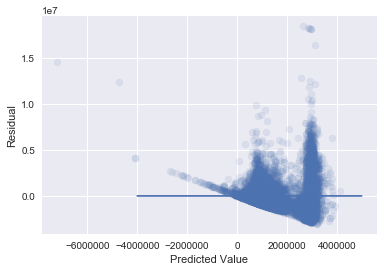

In [51]:
y_pred = results.predict(sm.add_constant(X))
plt.scatter(y_pred,y-y_pred,alpha=.1)
plt.plot(np.linspace(-4000000,5000000,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [78]:
def add_square_terms(df):    
    
    df_poly = df.copy()
    
    for c in df.columns:
        df_poly[c + '**2'] = df[c]**2
        
    return df_poly

In [79]:
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [80]:
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

#hold out 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [81]:
# Run on Linear Regression
lm = LinearRegression()
lm.fit(X_train, y_train)
print('OLS regression score val R^2: %.3f' % lm.score(X_val, y_val))
print('OLS regression score val RMSE: %.3f \n' % RMSE(lm.predict(X_val), y_val))

lm.fit(add_square_terms(X_train), y_train)
print('Squared terms regression val R^2: %.3f' 
      % lm.score(add_square_terms(X_val), y_val))
print('Squared terms regression score val RMSE: %.3f' 
      % RMSE(lm.predict(add_square_terms(X_val)), y_val))

OLS regression score val R^2: 0.421
OLS regression score val RMSE: 1.112 

Squared terms regression val R^2: -35375430579.787
Squared terms regression score val RMSE: 275075.523


In [82]:
list(zip(X_val.columns,lm.coef_))

[('Rating', -0.87866933536581804),
 ('review_count', 0.004255034715052515),
 ('1Star', -0.0023676753657051685),
 ('2Star', -0.0088503110048931185),
 ('3Star', 0.018208906291919472),
 ('4Star', 0.029436876131204957),
 ('5Star', -0.032152320145962206),
 ('style_count', -0.06726900463538836),
 ('days_since_launch', 0.00078286962621980198),
 ('weight_ounces', -0.0010410524482364482),
 ('volume', -4.1528176219766955e-05),
 ('min_price', 0.0010225595368493199)]

In [83]:
# Square Terms Linear Regression On Test Data
lm.fit(X, y)
print('Squared terms regression val R^2: %.3f' 
      % lm.score(X_test, y_test))
print('Squared terms regression score test RMSE: %.3f' 
      % RMSE(lm.predict(X_test), y_test))

Squared terms regression val R^2: 0.384
Squared terms regression score test RMSE: 1.165


Text(0,0.5,'Residual')

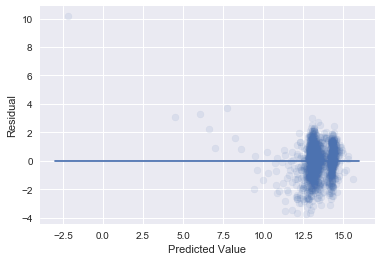

In [86]:
y_pred = lm.predict(X_test)

plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(-3,16,100),np.linspace(0,0,100))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

## Regularization and CV

In [89]:
from sklearn.model_selection import KFold


In [90]:
# Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

# this helps with the way kf will generate indices below
# Use X and not X_train because we're splitting again
arr_X = np.array(X)
arr_y = np.array(y)


for train_ind, val_ind in kf.split(arr_X,arr_y):
    
    X_kf_train, y_kf_train = arr_X[train_ind], arr_y[train_ind]
    X_kf_val, y_kf_val = arr_X[val_ind], arr_y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_kf_train, y_kf_train)
    cv_lm_r2s.append(lm.score(X_kf_val, y_kf_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_kf_train)
    X_val_scaled = scaler.transform(X_kf_val)
    
    lm_reg.fit(X_train_scaled, y_kf_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_kf_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print('Simple mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Ridge mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_reg_r2s),np.std(cv_lm_reg_r2s)))

Simple regression scores:  [0.43386767827371675, 0.43000616328266872, 0.44609620768775882, 0.38912114916131302, 0.38201250080101412]
Ridge scores:  [0.43394597266656199, 0.42992975992528459, 0.44627654124231775, 0.38933218670444913, 0.38192029151115425] 

Simple mean cv r^2: 0.416 +- 0.026
Ridge mean cv r^2: 0.416 +- 0.026


In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print('Ridge Regression test R^2:', lm_reg.score(X_test_scaled, y_test))

Ridge Regression test R^2: 0.384222498993


### Regularization with Alpha Testing

In [94]:
alphalist = 10**(np.linspace(-3,4,200))

err_vec_val_lasso = np.zeros(len(alphalist))
err_vec_val_ridge = np.zeros(len(alphalist))
err_vec_val_elastic = np.zeros(len(alphalist))
err_vec_val_base = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):
    pipe_lasso = Pipeline([('standardize', StandardScaler()), ('lasso', Lasso(alpha = curr_alpha))])
    pipe_ridge_lr = Pipeline([('standardize', StandardScaler()), ('ridge', Ridge(alpha = curr_alpha))])
    pipe_elastic_lr = Pipeline([('standardize', StandardScaler()), ('elasticnet', ElasticNet(alpha = curr_alpha))])
    pipe_base_lr = Pipeline([('standardize', StandardScaler()), ('linearregression', LinearRegression())])

    total_error_lasso = 0
    total_error_ridge = 0
    total_error_elastic = 0
    total_error_base = 0
    
    for train_ind, val_ind in kf.split(arr_X, arr_y):
        X_kf_train, y_kf_train = arr_X[train_ind], arr_y[train_ind]
        X_kf_val, y_kf_val = arr_X[val_ind], arr_y[val_ind]
        
        pipe_lasso.fit(X_kf_train, y_kf_train)
        pipe_ridge_lr.fit(X_kf_train, y_kf_train)
        pipe_elastic_lr.fit(X_kf_train, y_kf_train)
        pipe_base_lr.fit(X_kf_train, y_kf_train)
        
        val_pred_lasso = pipe_lasso.predict(X_kf_val)
        val_pred_ridge = pipe_ridge_lr.predict(X_kf_val)
        val_pred_elastic = pipe_elastic_lr.predict(X_kf_val)
        val_pred_base = pipe_base_lr.predict(X_kf_val)
        
#         test_error_lasso = np.sqrt(np.mean((val_pred_lasso - y_kf_val)**2))
#         test_error_ridge = np.sqrt(np.mean((val_pred_ridge - y_kf_val)**2))
#         test_error_elastic = np.sqrt(np.mean((val_pred_elastic - y_kf_val)**2))
#         test_error_base = np.sqrt(np.mean((val_pred_base - y_kf_val)**2))

        total_error_lasso += np.sqrt(np.mean((val_pred_lasso - y_kf_val)**2))
        total_error_ridge += np.sqrt(np.mean((val_pred_ridge - y_kf_val)**2))
        total_error_elastic += np.sqrt(np.mean((val_pred_elastic - y_kf_val)**2))
        total_error_base += np.sqrt(np.mean((val_pred_base - y_kf_val)**2))
        
    err_vec_val_lasso[i] = total_error_lasso
    err_vec_val_ridge[i] = total_error_ridge
    err_vec_val_elastic[i] = total_error_elastic
    err_vec_val_base[i] = total_error_base

    
# Print value of alpha with lowest error, and minimum error achieved on the test set across all alpha 
print('Lasso: ', alphalist[np.argmin(err_vec_val_lasso)], ',', np.min(err_vec_val_lasso))
print('Ridge: ', alphalist[np.argmin(err_vec_val_ridge)], ',', np.min(err_vec_val_ridge))
print('ElasticNet: ', alphalist[np.argmin(err_vec_val_elastic)], ',', np.min(err_vec_val_elastic))
print('LinearRegression: ', alphalist[np.argmin(err_vec_val_base)], ',', np.min(err_vec_val_base))

best_alpha_lasso = alphalist[np.argmin(err_vec_val_lasso)]
best_alpha_ridge = alphalist[np.argmin(err_vec_val_ridge)]
best_alpha_elastic = alphalist[np.argmin(err_vec_val_elastic)]
best_alpha_base = alphalist[np.argmin(err_vec_val_base)]



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Lasso:  0.00117584955405 , 5.57001170239
Ridge:  27.0495973046 , 5.56731702876
ElasticNet:  0.00264308148697 , 5.56907499277
LinearRegression:  0.001 , 5.57006296472


### on log-transformed data

Lasso:  alpha - 0.00117584955405 , error - 5.57001170239

Ridge:  alpha - 27.0495973046 , error - 5.56731702876

ElasticNet:  alpha - 0.00264308148697 , error - 5.56907499277

LinearRegression:  alpha - 0.001 , error - 5.57006296472


### on non log-transformed data

Lasso:  alpha - 10,000.0 , error - 18,755,371.3512

Ridge:  alpha - 3,557.15020682 , error - 8,999,775.43887

ElasticNet:  alpha - 1.18071284667 , error - 8,999,777.10383

LinearRegression:  alpha - 0.001 , error - 20,612,823.5657


In [95]:
## Data Scaling
std = StandardScaler()
std.fit(X)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X)
X_te = std.transform(X_test)

In [96]:
ridge = Ridge(alpha=best_alpha_ridge)
elasticnet = ElasticNet(best_alpha_elastic)

In [97]:
ridge.fit(X_tr, y)
elasticnet.fit(X_tr, y)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0026430814869741054, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [70]:
print('ridge: ', ridge.score(X_te, y_test))
print('elasticnet: ', elasticnet.score(X_te, y_test))

ridge:  0.226352859425
elasticnet:  0.221034336523


In [116]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,6,200)

lr_model8 = LassoCV(alphas = alphavec, cv=5)
lr_model8.fit(X_tr,y)

LassoCV(alphas=array([  1.00000e-03,   1.10975e-03, ...,   9.01102e+05,   1.00000e+06]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [117]:
# This is the best alpha value it found
lr_model8.alpha_

0.0018679135990207828

In [118]:
# Make predictions on the test set using the new model
test_set_pred8 = lr_model8.predict(X_te)

In [119]:
# R^2
lr_model8.score(X_te, y_test)

0.38805812243836108

In [104]:
np.sqrt(np.mean((test_set_pred8 - y_test)**2))

1.1613629496465196

In [120]:
# Coefficients
list(zip(X.columns,lr_model8.coef_))

[('Rating', -0.54469815556496626),
 ('review_count', -0.0),
 ('1Star', -0.11895895363381222),
 ('2Star', -0.20419139186093502),
 ('3Star', 0.32427105845602422),
 ('4Star', 0.60913895673427221),
 ('5Star', -1.2407339875504226),
 ('style_count', -0.11443791928010684),
 ('days_since_launch', 0.22739447210665165),
 ('weight_ounces', -0.077037026653424268),
 ('volume', 0.002933806786751059),
 ('min_price', 0.033274597991624862)]

In [121]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso', verbose=True)

Computing regularization path using the LARS ...
.

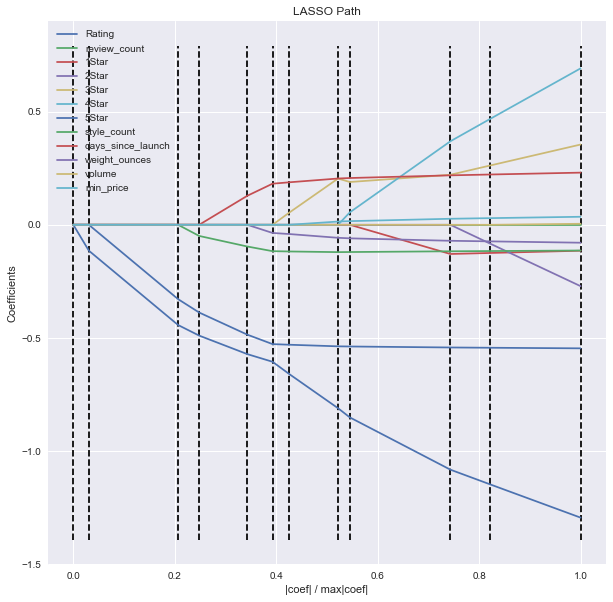

In [122]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [123]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=1800, max_features=3)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.67877332747357366

Text(0,0.5,'Residual')

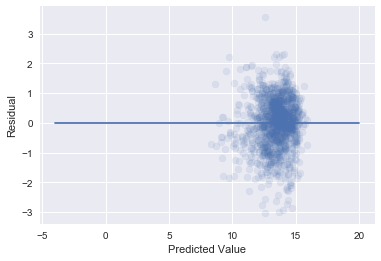

In [124]:
y_pred = rf.predict(X_test)
plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(-4,20,100),np.linspace(0,0,100))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')


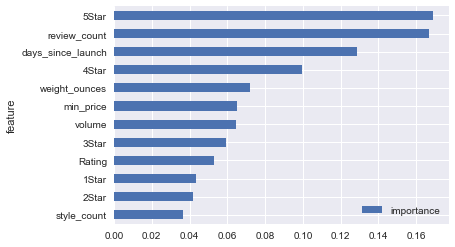

In [125]:
feat_imps = list(zip(X_train.columns,rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [126]:
rf.score(X_test, y_test)

0.67835287473601802